<a href="https://colab.research.google.com/github/mtermor/DL_Fundamentals/blob/main/NN_fundamentals_Solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=plt.cm.Spectral)

def load_planar_dataset(m, sigma=0.2):
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*sigma # theta
        r = a*np.sin(4*t) + np.random.randn(N)*sigma # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    ## premuting ouput
    p = np.random.permutation(m)
    X = X[p,:]
    Y = Y[p,:]

    return X, Y.ravel()

def draw_neural_net(left, right, bottom, top, layer_sizes):
    '''
    From https://gist.github.com/craffel/2d727968c3aaebd10359#file-draw_neural_net-py
    Draw a neural network cartoon using matplotilb.

    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])

    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    fig = plt.figure(figsize=(3, 3))
    ax = fig.gca()
    ax.axis('off')

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

## Dataset

We have a binary classification dataset. The target `y` has two possible values {0,1} and the input vector `x` has two dimensions.

In [3]:
N = 5000
X, y = load_planar_dataset(N, 0.2)

Visualize the dataset using matbplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. YOur goal is to build a model to fit this data.

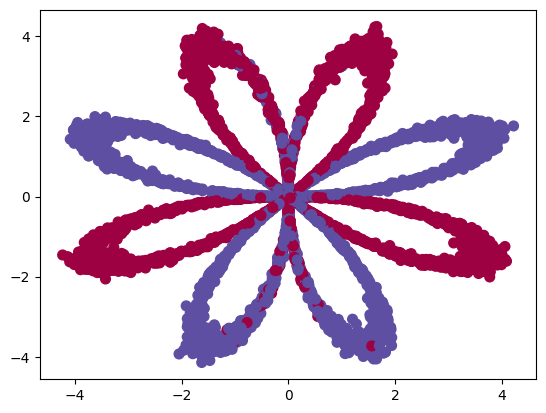

In [4]:
# Visualize the data
plt.scatter(X[:,0], X[:,1], c = y.ravel(), s= 49, cmap= plt.cm.Spectral)

"""
c: carray-like or list of colors or color, optional
y.ravel(): Return a contiguous flattened array (in this case it is equivalent to y)
cmap: The Colormap instance or registered colormap name used to map scalar data to colors.

X values plotted, coloured by y (like hue in sns library)
""";

In [5]:
# Train-test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.2)

In [6]:
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape, y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(4000, 2), y_train shape:(4000,)
X_test shape:(1000, 2), y_test shape:(1000,)


In [7]:
## X first example
X[0,:]

array([-3.5194003 , -1.10474371])

In [8]:
## Y firsts examples
y[:8]

array([0, 0, 0, 1, 1, 0, 1, 0], dtype=uint8)

## First NN in Keras

### Logistic regression

Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class. We can specify the number of neurons as the first argument, and specify the activation function using the activation argument.

```python
tf.keras.layers.Dense(
    units, activation=None
)

```

- **units**: Number of neurons in the layer.
- **activation**: Activation function to use, default function is `linear`, you can also use `sigmoid` for sigmoid activation or [other alternatives](https://www.tensorflow.org/api_docs/python/tf/keras/activations)

For defining the input layer you can use `keras.Input(shape=(input_dimension,))` or define your input dimension in the first hidden layer.

```python
layers.Dense(4, activation="sigmoid", input_shape=(input_dimension,))

```

Build a network without hidden layer

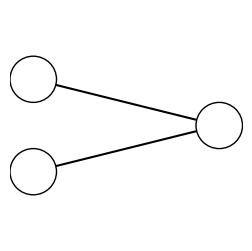

In [9]:
draw_neural_net(0.1, 0.9, 0.1, 0.9, [2,1]) # custom function

In [10]:
### https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

model = keras.Sequential()
# The dimension of the input is 2 (planar data)
# We have only one output layer with 1 neuron
model.add(
    keras.layers.Dense(1, input_shape=(2, ), activation="sigmoid")
)
model.summary()
# 3 parameters: 2 weight parameters + 1 beta

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


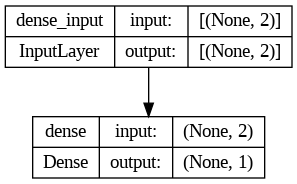

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes= True)

#### Compile
Now we need to specify the loss function, the metrics and the optimizer. It is done using compile function in Keras.

In [12]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

#### Training model
This is similar to a sklearn model.

In [13]:
model.fit(X_train, y_train, epochs = 10, validation_split = 0.2, batch_size = 32)

"""
ephocs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
        (unless the steps_per_epoch flag is set to something other than None). Note that in conjunction with
        initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations
        given by epochs, but merely until the epoch of index epochs is reached.
batch_size : Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
        Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.PyDataset
        instances (since they generate batches).
validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will
        set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model
        metrics on this data at the end of each epoch. The validation data is selected from the last samples in the
        x and y data provided, before shuffling. This argument is not supported when x is a dataset, generator or
        keras.utils.PyDataset instance. If both validation_data and validation_split are provided, validation_data
        will override validation_split.
""";

Epoch 1/10
100/100 [==============================] - 5s 18ms/step - loss: 1.2138 - accuracy: 0.3756 - val_loss: 1.1398 - val_accuracy: 0.3963
Epoch 2/10
100/100 [==============================] - 1s 9ms/step - loss: 1.1134 - accuracy: 0.3859 - val_loss: 1.0486 - val_accuracy: 0.4075
Epoch 3/10
100/100 [==============================] - 1s 10ms/step - loss: 1.0217 - accuracy: 0.4022 - val_loss: 0.9666 - val_accuracy: 0.4212
Epoch 4/10
100/100 [==============================] - 2s 17ms/step - loss: 0.9400 - accuracy: 0.4200 - val_loss: 0.8946 - val_accuracy: 0.4462
Epoch 5/10
100/100 [==============================] - 1s 13ms/step - loss: 0.8698 - accuracy: 0.4456 - val_loss: 0.8345 - val_accuracy: 0.4638
Epoch 6/10
100/100 [==============================] - 1s 10ms/step - loss: 0.8118 - accuracy: 0.4725 - val_loss: 0.7849 - val_accuracy: 0.4938
Epoch 7/10
100/100 [==============================] - 1s 8ms/step - loss: 0.7657 - accuracy: 0.4975 - val_loss: 0.7477 - val_accuracy: 0.5013
E

### Making predictions

In [14]:
results = model.evaluate(X_test, y_test, verbose = 0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

"""
Verbosity mode. 0 = silent, 1 = progress bar, 2 = single line.

Outputs: Scalar test loss (if the model has a single output and no metrics) or list of scalars (if the model has
multiple outputs and/or metrics). The attribute model.metrics_names will give you the display labels for the
scalar outputs.

Test loss: to be as small as possible
Test accuracy: to be as large as possible
""";

Test Loss: 0.6948076486587524
Test Accuracy: 0.6470000147819519


In [15]:
y_pred = model.predict(X_test, verbose = 0)
y_pred[:3], y_test[:3]

(array([[0.39218712],
        [0.5853244 ],
        [0.53997695]], dtype=float32),
 array([1, 1, 1], dtype=uint8))

31689/31689 [==============================] - 46s 1ms/step


Text(0.5, 1.0, 'Basic NN')

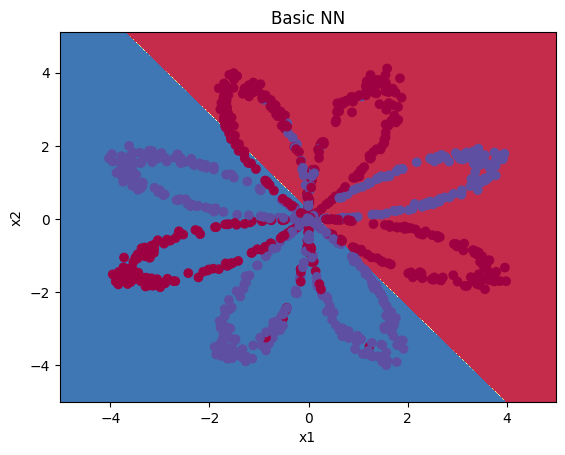

In [16]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("Basic NN")

### One hidden layer NN

- One **input with 2 features (input_shape)**
- **One hidden dense layer**,  with **3 neurons** and implemented with  **sigmoid activating function**
- **One Output** (sigmoid output activation function)

We can create layers incrementally with the method `add()`:

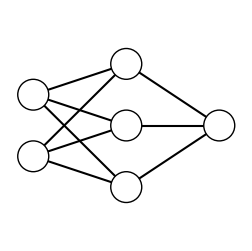

In [17]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 1])

In [18]:
model = keras.Sequential()
model.add(keras.layers.Dense(3, input_shape=(2, ), activation="sigmoid"))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.summary()

# L1 - 9 parameters: 6 weight parameters (6 neuron links) + 3 beta (one per node)
# L2 - 4 parameters: 3 weight parameters (3 neuron links) + 1 beta (one per node)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 3)                 9         
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


You can also define the model with a list of layers
```python
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='sigmoid', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])
````

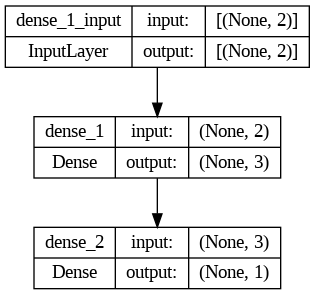

In [19]:
plot_model(model, show_shapes=True)

In [20]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 2s 8ms/step - loss: 0.6856 - accuracy: 0.5113 - val_loss: 0.6869 - val_accuracy: 0.4988
Epoch 2/25
100/100 [==============================] - 1s 8ms/step - loss: 0.6792 - accuracy: 0.5769 - val_loss: 0.6812 - val_accuracy: 0.6112
Epoch 3/25
100/100 [==============================] - 1s 5ms/step - loss: 0.6746 - accuracy: 0.6403 - val_loss: 0.6767 - val_accuracy: 0.6350
Epoch 4/25
100/100 [==============================] - 1s 6ms/step - loss: 0.6703 - accuracy: 0.6263 - val_loss: 0.6723 - val_accuracy: 0.6237
Epoch 5/25
100/100 [==============================] - 1s 7ms/step - loss: 0.6658 - accuracy: 0.6191 - val_loss: 0.6679 - val_accuracy: 0.6225
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6610 - accuracy: 0.6156 - val_loss: 0.6634 - val_accuracy: 0.6175
Epoch 7/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6561 - accuracy: 0.6175 - val_loss: 0.6589 - val_accuracy: 0.6187
Epoch 

In [21]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

Test Loss: 0.5931710004806519
Test Accuracy: 0.6119999885559082


31689/31689 [==============================] - 64s 2ms/step


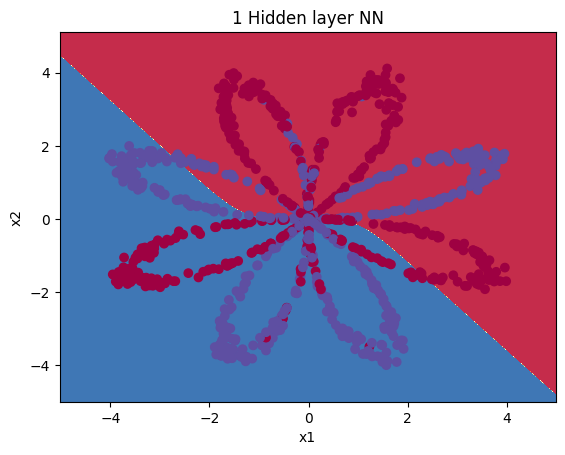

In [22]:
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN");

### Question 1:
####  What happens if we change the activation function of the first hidden  layer to `'linear'`?

In [23]:
model = keras.Sequential([
    keras.Input(shape=(2, )),
    layers.Dense(3, activation='linear', name='layer1'),
    layers.Dense(1, activation='sigmoid', name='layer3')
])

## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Epoch 1/25
100/100 [==============================] - 2s 7ms/step - loss: 1.0625 - accuracy: 0.3534 - val_loss: 0.9048 - val_accuracy: 0.3762
Epoch 2/25
100/100 [==============================] - 0s 4ms/step - loss: 0.8421 - accuracy: 0.3681 - val_loss: 0.7570 - val_accuracy: 0.3900
Epoch 3/25
100/100 [==============================] - 1s 5ms/step - loss: 0.7266 - accuracy: 0.3866 - val_loss: 0.6951 - val_accuracy: 0.4650
Epoch 4/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6794 - accuracy: 0.5169 - val_loss: 0.6746 - val_accuracy: 0.4850
Epoch 5/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6633 - accuracy: 0.4825 - val_loss: 0.6692 - val_accuracy: 0.4613
Epoch 6/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6588 - accuracy: 0.4744 - val_loss: 0.6686 - val_accuracy: 0.4613
Epoch 7/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6580 - accuracy: 0.4762 - val_loss: 0.6686 - val_accuracy: 0.4600
Epoch 

Test Loss: 0.6664076447486877
Test Accuracy: 0.45399999618530273
31689/31689 [==============================] - 62s 2ms/step


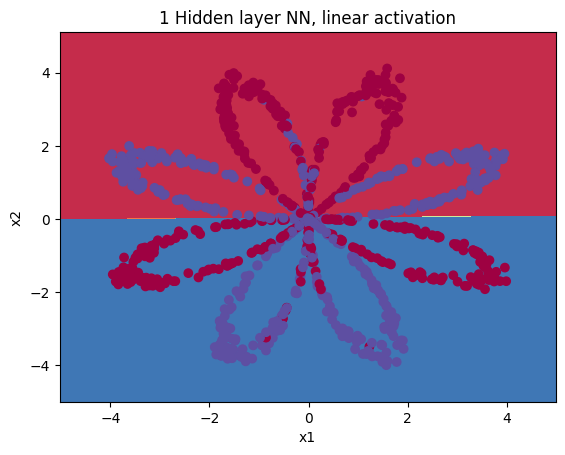

In [24]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 2:
####  What happens if we add more neurons to the first hidden layer ?

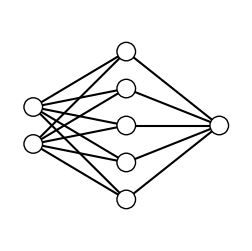

In [25]:
draw_neural_net(.1, .9, .1, .9, [2, 5, 1])

In [26]:
model = keras.Sequential()
model.add(keras.layers.Dense(5, input_shape=(2, ), activation="sigmoid"))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.summary()

## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 5)                 15        
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 21 (84.00 Byte)
Trainable params: 21 (84.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
100/100 [==============================] - 2s 10ms/step - loss: 0.7062 - accuracy: 0.5803 - val_loss: 0.6999 - val_accuracy: 0.5600
Epoch 2/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6815 - accuracy: 0.6194 - val_loss: 0.6815 - val_accuracy: 0.6212
Epoch 3/25
100/100 [==============================] - 0s 2ms/step - loss: 0.6691 - accuracy: 0.6566 - val_loss: 0.6719 - val_accura

Test Loss: 0.5471820831298828
Test Accuracy: 0.7179999947547913
31689/31689 [==============================] - 62s 2ms/step


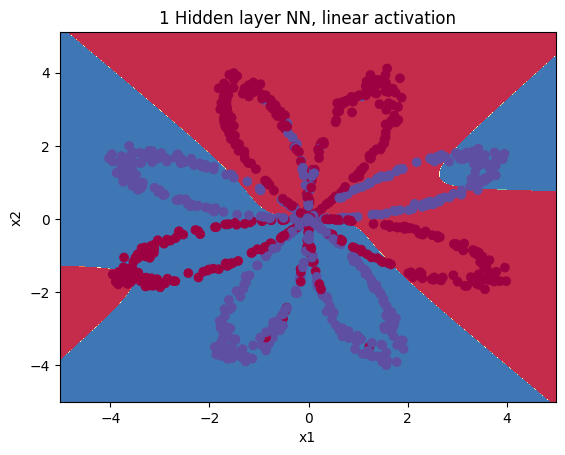

In [27]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

### Question 3:
####  What happens if we add one more hidden layer ?

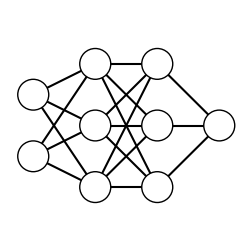

In [28]:
draw_neural_net(.1, .9, .1, .9, [2, 3, 3, 1])

In [29]:
model = keras.Sequential()
model.add(keras.layers.Dense(3, input_shape=(2, ), activation="sigmoid"))
model.add(keras.layers.Dense(3, activation="sigmoid"))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.summary()

## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 3)                 9         
                                                                 
 dense_6 (Dense)             (None, 3)                 12        
                                                                 
 dense_7 (Dense)             (None, 1)                 4         
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
100/100 [==============================] - 2s 6ms/step - loss: 0.7116 - accuracy: 0.4931 - val_loss: 0.6986 - val_accuracy: 0.5163
Epoch 2/25
100/100 [==============================] - 0s 4ms/step - loss: 0.7005 - accuracy: 0.4694 - val_loss: 0.6959 - val_accuracy: 0.443

Test Loss: 0.617944598197937
Test Accuracy: 0.6449999809265137
31689/31689 [==============================] - 58s 2ms/step


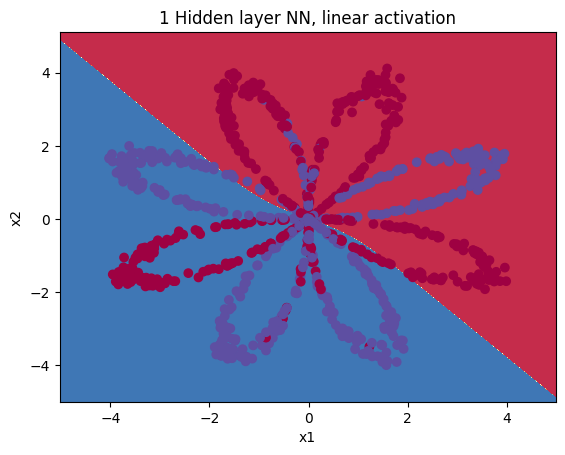

In [30]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

####  Use  the [hyperbolic tangent](https://mathworld.wolfram.com/HyperbolicTangent.html) activation `'tanh'` with the first simple model and compare the results with the sigmoid activation

In [31]:
model = keras.Sequential()
## The first layer need to have the input_shape
## change the activation function
model.add(layers.Dense(3, input_shape=(2,), activation='tanh'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 3)                 9         
                                                                 
 dense_9 (Dense)             (None, 1)                 4         
                                                                 
Total params: 13 (52.00 Byte)
Trainable params: 13 (52.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
100/100 [==============================] - 1s 4ms/step - loss: 0.7875 - accuracy: 0.3397 - val_loss: 0.7514 - val_accuracy: 0.3150
Epoch 2/25
100/100 [==============================] - 0s 3ms/step - loss: 0.7346 - accuracy: 0.3406 - val_loss: 0.7097 - val_accuracy: 0.3625
Epoch 3/25
100/100 [==============================] - 0s 3ms/step - loss: 0.6952 - accuracy: 0.3887 - val_loss: 0.6801 - val_accurac

Test Loss: 0.38757237792015076
Test Accuracy: 0.8989999890327454
31689/31689 [==============================] - 74s 2ms/step


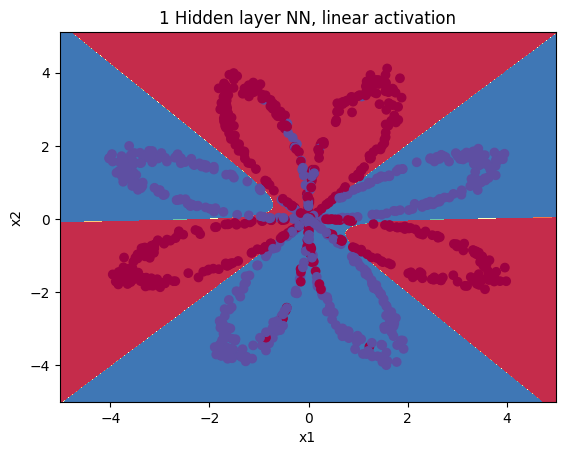

In [32]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)
plt.title("1 Hidden layer NN, linear activation");

## Practice I

Repeat the process with a different dataset.

In [33]:
N = 5000
X, y = sklearn.datasets.make_moons(n_samples=N, noise=.18)

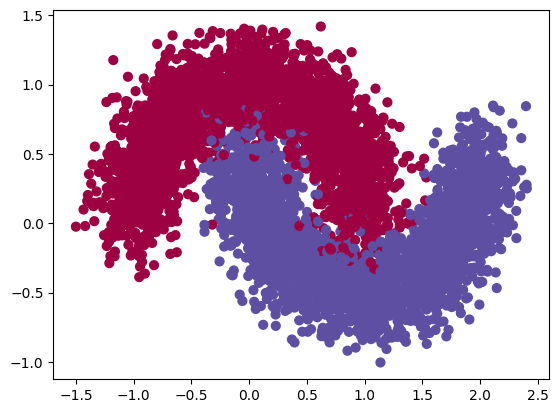

In [34]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [35]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

In [36]:
model = keras.Sequential()
## The first layer need to have the input_shape
model.add(layers.Dense(16, input_shape=(2,), activation='tanh'))

## Second Layer, don't use input_shape
model.add(layers.Dense(16, activation='tanh'))

# output layer
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                48        
                                                                 
 dense_11 (Dense)            (None, 16)                272       
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 337 (1.32 KB)
Trainable params: 337 (1.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/35
47/47 [==============================] - 2s 12ms/step - loss: 0.5555 - accuracy: 0.7333 - val_loss: 0.4692 - val_accuracy: 0.7853
Epoch 2/35
47/47 [==============================] - 0s 7ms/step - loss: 0.4033 - accuracy: 0.8297 - val_loss: 0.3848 - val_accuracy: 0.8253
Epoch 3

Test Loss: 0.11444646120071411
Test Accuracy: 0.9631999731063843
7738/7738 [==============================] - 17s 2ms/step


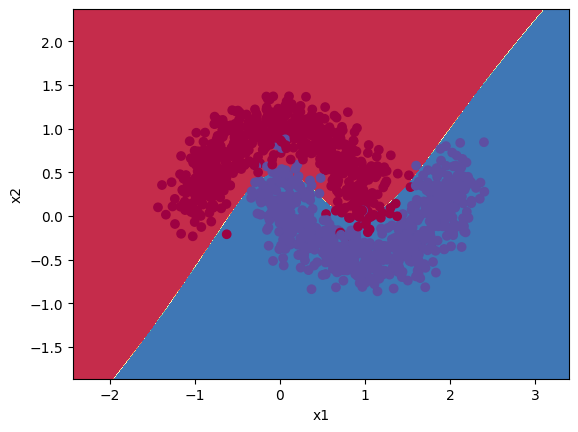

In [37]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)

## Functional API

The Keras Functional API allows defining the topology of the models as a [acyclic directed graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph) of layers. Next we will build the same model as in the previous section but using the Keras Functional API.

You need to start with an input data entry:
```python    
    inputs = keras.Input(shape=(8,))
```
    
We define the layers that we will include in the network and the relationships between them. It is important to note that each line details the type of layer and its properties (number of neurons, activation function, name ...) and just at the end, in parentheses, the name of the variable in which we have saved the layer from which its output will connect to the input of the layer we are declaring.
```python
layer_1 = layers.Dense(4, activation='sigmoid',
                       name='layer_1')(inputs)
layer_2 = layers.Dense(4, activation='sigmoid',
                       name='layer_2')(layer_1)
```

The "layer call" `Dense()(inputs)` action is like drawing an arrow from "inputs" to this layer you created. You're "passing" the inputs to the dense layer, and you get `layer_1` as the output.

  

Finally, we define the network outputs:
```python
outputs = layers.Dense(1, name='output_layer')(layer_2)
```

We create the model specifying the inputs and outputs:
```python
model = keras.Model(inputs=inputs, outputs=outputs)
```

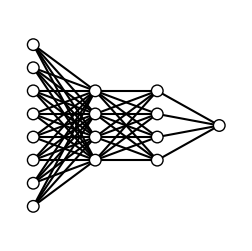

In [38]:
draw_neural_net(.1, .9, .1, .9, [8, 4, 4, 1])

In [39]:
inputs = keras.Input(shape=(8, ), name='input_layer')
l_1 = layers.Dense(4, activation='relu', name='layer_1')(inputs)
l_2 = layers.Dense(4, activation='relu', name='layer_2')(l_1)
outputs = layers.Dense(1, name='output_layer')(l_2)

model = keras.Model(inputs=inputs, outputs=outputs, name='example_model')

model.summary()

Model: "example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 8)]               0         
                                                                 
 layer_1 (Dense)             (None, 4)                 36        
                                                                 
 layer_2 (Dense)             (None, 4)                 20        
                                                                 
 output_layer (Dense)        (None, 1)                 5         
                                                                 
Total params: 61 (244.00 Byte)
Trainable params: 61 (244.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


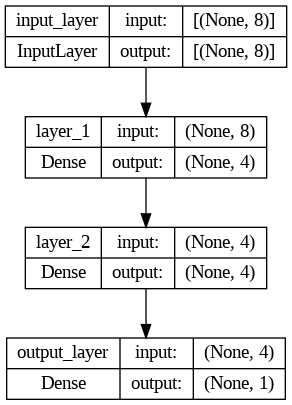

In [40]:
plot_model(model, show_shapes=True)

## Practice II

Repeat the process with a different dataset and the **Functional API**

In [41]:
N = 5000
X, y = sklearn.datasets.make_circles(n_samples=N, factor=.65, noise=.065) # sklearn.datasets.make_moons(n_samples=N, noise=.15)

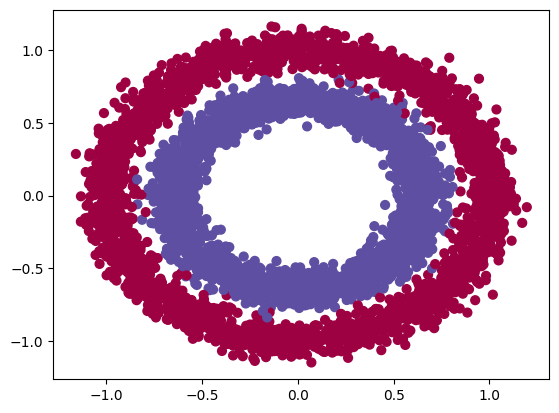

In [42]:
# Visualize the data:
plt.scatter(X[:,0], X[:,1], c=y.ravel(), s=40, cmap=plt.cm.Spectral);

In [43]:
# train test split
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(
    X,
    y,
    test_size=0.25,
)
print('X shape:{0}, y shape:{1}'.format(X.shape, y.shape))
print('X_train shape:{0}, y_train shape:{1}'.format(X_train.shape,
                                                    y_train.shape))
print('X_test shape:{0}, y_test shape:{1}'.format(X_test.shape, y_test.shape))

X shape:(5000, 2), y shape:(5000,)
X_train shape:(3750, 2), y_train shape:(3750,)
X_test shape:(1250, 2), y_test shape:(1250,)


### Define your model

In [44]:
inputs = keras.Input(shape=(2, ), name='input_layer')
## First hidden layer
l_1 = layers.Dense(32, activation='relu')(inputs)
l_2 = layers.Dense(32, activation='relu')(l_1)

## output layer
outputs = layers.Dense(1, activation='sigmoid')(l_2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 dense_13 (Dense)            (None, 32)                96        
                                                                 
 dense_14 (Dense)            (None, 32)                1056      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1185 (4.63 KB)
Trainable params: 1185 (4.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
## compiling and training
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.fit(X_train, y_train, epochs=35, validation_split=0.2, batch_size=64)

Epoch 1/35
47/47 [==============================] - 3s 13ms/step - loss: 0.6839 - accuracy: 0.5147 - val_loss: 0.6660 - val_accuracy: 0.5307
Epoch 2/35
47/47 [==============================] - 0s 9ms/step - loss: 0.6605 - accuracy: 0.5030 - val_loss: 0.6350 - val_accuracy: 0.5427
Epoch 3/35
47/47 [==============================] - 0s 8ms/step - loss: 0.6213 - accuracy: 0.6180 - val_loss: 0.5854 - val_accuracy: 0.8013
Epoch 4/35
47/47 [==============================] - 0s 10ms/step - loss: 0.5498 - accuracy: 0.8740 - val_loss: 0.4910 - val_accuracy: 0.9560
Epoch 5/35
47/47 [==============================] - 0s 5ms/step - loss: 0.4408 - accuracy: 0.9647 - val_loss: 0.3738 - val_accuracy: 0.9907
Epoch 6/35
47/47 [==============================] - 0s 5ms/step - loss: 0.3196 - accuracy: 0.9867 - val_loss: 0.2639 - val_accuracy: 0.9947
Epoch 7/35
47/47 [==============================] - 0s 6ms/step - loss: 0.2193 - accuracy: 0.9910 - val_loss: 0.1800 - val_accuracy: 0.9960
Epoch 8/35
47/47 [

Test Loss: 0.012030740268528461
Test Accuracy: 0.9991999864578247
5765/5765 [==============================] - 12s 2ms/step


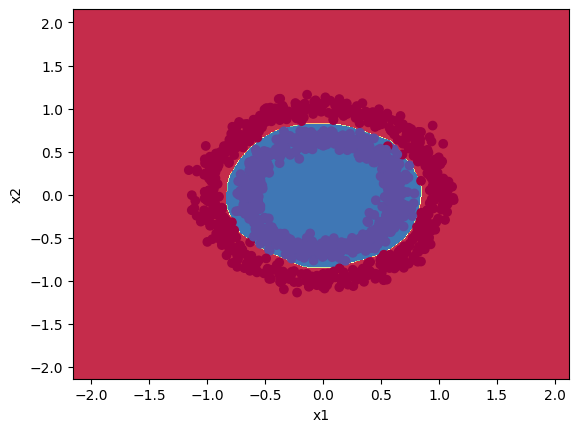

In [46]:
results = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))
plot_decision_boundary(lambda x: (
    model.predict(x) > 0.5).astype("int32"), X_test, y_test)